In [1]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import tensorflow as tf

In [2]:
df = pd.read_csv('/Users/hamzehshibly/Desktop/ProgressSoft/task2/trainMa.csv')

In [3]:
directory = "/Users/hamzehshibly/Desktop/ProgressSoft/task2/Medical mask/Medical Mask/trainedIMAGES"
image_directory = '/Users/hamzehshibly/Desktop/ProgressSoft/task2/Medical mask/Medical Mask/trainIMAGES'

In [4]:
cvNet = cv2.dnn.readNetFromCaffe('/Users/hamzehshibly/Desktop/ProgressSoft/task2/architecture.txt',
                                 '/Users/hamzehshibly/Desktop/ProgressSoft/task2/weights.caffemodel')

In [5]:
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
          return json.load(f)

In [6]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [7]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            data.append([img,labels["without mask"]])
random.shuffle(data)    

In [9]:
my_model =tf.keras.models.load_model('trainedMODEL.h5')

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-21 15:39:58.593462: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-21 15:39:58.593559: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
my_model

1/1 [==============================] - 0s 11ms/step


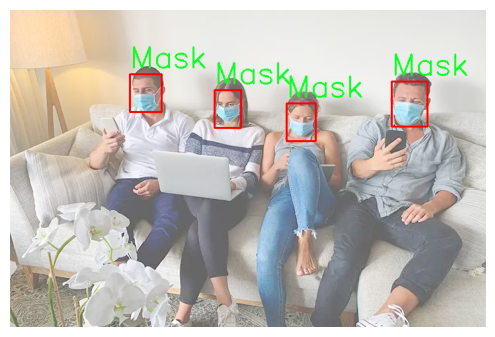

In [35]:
images = ['/Users/hamzehshibly/Desktop/ProgressSoft/task3/family-mask2.webp']
gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in enumerate(images):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = my_model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()